# Convex Optimization Exam
## Author: Clément Bonnet

---

## Exercise 6

Let (P) be a primal problem and (D) its dual.

\begin{align*}
    & \begin{aligned}
    (P):\quad
        & \underset{w \in \mathbb{R}^n, z \in \mathbb{R}^m}{\text{minimize}}
        & & \frac{1}{2} \lVert w \rVert_2^2 + C\mathrm{1}^Tz \\
        & \text{subject to}
        & & y_i(w^Tx_i) \geq 1 - z_i, \forall i = 1 \cdots n \\
        & & & z \succeq 0
    \end{aligned} \\
    & \begin{aligned}
    (D):\quad
        & \underset{\alpha \in \mathbb{R}^m}{\text{minimize}}
        & &  f(\alpha) = \frac{1}{2} \Big\lVert \sum_{i=1}^m \alpha_i y_i x_i \Big\rVert_2^2 - \mathrm{1}^T \alpha \\
        & \text{subject to}
        & & 0 \preceq \alpha \preceq C\mathrm{1} \\
    \end{aligned}
\end{align*}

After including the log-barrier for the dual problem, the function $f_t$ to minimize now becomes:
\begin{equation*}
    f_t(\alpha) = \frac{t}{2} \Big\lVert \sum_{i=1}^m \alpha_i y_i x_i \Big\rVert_2^2 - t \mathrm{1}^T \alpha - \sum_{i=1}^m \log(\alpha_i(C - \alpha_i)) \\
\end{equation*}

One can derive its gradient $\nabla f_t$:
\begin{equation*}
    \nabla f_t(\alpha)_i = t y_i \Big(\sum_{k=1}^m \alpha_k y_k x_k \Big)^Tx_i -t -\frac{1}{\alpha_i} - \frac{1}{C - \alpha_i} \\
\end{equation*}

Finally, the hessian matrix follows from differentiating the gradient.
\begin{equation*}
    \nabla^2 f_t(v)_{i,j} =
    \begin{cases}
      t y_i y_j x_j^Tx_i, & \text{if}\ i \neq j \\
      t y_i^2x_i^Tx_i + \frac{1}{\alpha_i^2} - \frac{1}{(C - \alpha_i)^2}, & \text{if}\ i = j
    \end{cases} \\
\end{equation*}

Once the optimal value $\alpha^\star$ of the dual problem is found, one can recover the optimal solution $w^\star$ of the primal using the KKT conditions. At the optimum,
\begin{align*}
    &\nabla_w L(w, z, \mu, \alpha) = 0 = w^\star - \sum_{i=1}^m \alpha_i^\star y_i x_i \\
    &\implies \boxed{w^\star = \sum_{i=1}^m \alpha_i^\star y_i x_i}
\end{align*}

In [1]:
# Import statements

import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Auxiliary functions

def in_domain(a, c):
    """
    Check whether a is in the domain of function f_t. So that log can be defined.
    """
    return (a < c).all() & (a > 0).all()

def backtrack(x, y, c, t, a, eps, alpha, beta, step_dir, grad):
    """
    Backtracking line search.
    Return the right step_size for next update.
    """
    f_t = lambda a: t/2 * np.linalg.norm(((a.reshape(-1,1))*(y.reshape(-1,1))*x).sum(axis=0))**2 - t*a.sum() - np.log(a*(c-a)).sum()
    a_back = a.copy()
    step_size = 1
    backtrack_crit = False
    while not backtrack_crit:
        step_size *= beta
        if in_domain(a_back + step_size*step_dir, c):
            backtrack_crit = f_t(a_back + step_size*step_dir) < f_t(a_back) + alpha*step_size*grad.T@step_dir
    return step_size

In [3]:
# Barrier method implementation

def centering_step(x, y, c, t, a, eps, alpha, beta, verbose=False):
    """
    Centering step.
    """    
    # Side effect on a
    m = len(y)
    seq = [a.copy()]
    center_crit = False
    while not center_crit:
        # Compute gradient and hessian matrix 
        grad = np.zeros(m)
        for i in range(m):
            grad[i] = t*y[i]*((a.reshape(-1,1))*(y.reshape(-1,1))*x).sum(axis=0)@x[i,:] -t -1/a[i] -1/(c - a[i])
        hess = np.zeros((m,m))
        for i in range(m):
            for j in range(m):
                hess[i,j] = t*y[i]*y[j]*x[i,:]@x[j,:]
        hess = hess + np.diag(1/a**2 - 1/(c-a)**2)
        # Newton step
        step_dir = np.linalg.solve(hess, -grad)
        # Newton decrement
        squared_decr = -grad.T @ step_dir
        center_crit = squared_decr/2 <= eps
        if verbose: print("Squared decrement:", squared_decr)
        if center_crit: break
        # Backtracking line search
        step_size = backtrack(x, y, c, t, a, eps, alpha, beta, step_dir, grad)
        a += step_size*step_dir
        seq.append(a.copy())
    return seq

def barr_method(x, y, c, a0, eps=1e-3, mu=10, t0=1, alpha=0.1, beta=0.5, verbose=False):
    """
    Barrier method to solve the dual problem.
    Returns a sequence of values until the optimum.
    """
    t = t0
    m = len(y)
    seq = []
    a = a0.copy()
    while m/t >= eps:
        t *= mu
        seq.extend(centering_step(x, y, c, t, a, eps, alpha, beta, verbose))
    return seq

In [4]:
# Plotting functions

def print_duality_gap(seq, x, y, c=None, color=None):
    f = lambda a: 1/2 * np.linalg.norm(((a.reshape(-1,1))*(y.reshape(-1,1))*x).sum(axis=0))**2 - a.sum()
    f_seq_arr = np.array([f(seq_i) for seq_i in seq])
    i_star, f_star = np.argmin(f_seq_arr), f_seq_arr.min()
    a_star = np.array(seq)[i_star]
    w_star = ((a_star.reshape(-1,1))*(y.reshape(-1,1))*x).sum(axis=0)
    to_plot = [abs(f_seq_arr_i - f_star) for i, f_seq_arr_i in enumerate(f_seq_arr) if i != i_star]
    plt.step(range(len(to_plot)), to_plot, label="C = {}".format(c), color=color);
    plt.yscale("log");
    plt.xlabel("Number of iterations");
    plt.ylabel("Duality gap");
    plt.legend();
    plt.title("Barrier method on dual problem");
    return a_star, w_star
    
def plot_all(c_list, m=10, n=2, eps=1e-3, random_seed=0, plot_points=True, zoom=True):
    np.random.seed(random_seed)
    means = np.array([[-1, 1], [1, -1]])
    sigmas = np.array([[[1, 0],[0, 1]], [[1, 0],[0, 1]]])
    x = np.zeros((m,n))
    y = np.zeros(m)
    for i in range(m):
        k = 0 if np.random.rand() > 0.5 else 1
        x[i,:] = np.random.multivariate_normal(means[k], sigmas[k])
        y[i] = 2*k - 1
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(c_list)))
    w_stars = np.zeros((len(c_list), n))
    a_stars = np.zeros((len(c_list), m))
    plt.figure(figsize=(8,6));
    for i, c in enumerate(c_list):
        a0 = c * np.random.rand(m)
        seq = barr_method(x, y, c, a0, eps=eps)
        a_star, w_star = print_duality_gap(seq, x, y, c, colors[i])
        a_stars[i] = a_star
        w_stars[i] = w_star
    if plot_points:
        plt.figure(figsize=(8,6));
        plt.scatter(x[:,0][y==-1], x[:,1][y==-1], color="blue");
        plt.scatter(x[:,0][y==1], x[:,1][y==1], color="red");
        plt.xlabel("$x_1$");
        plt.ylabel("$x_2$");
        plt.title("Solutions found by the algorithm on random clouds of points");
        x_w = np.linspace(-3, 3, 100)
        for i, w_star in enumerate(w_stars):
            y_w = -w_star[0]/w_star[1] * x_w
            plt.plot(x_w, y_w, label="C = {}".format(c_list[i]), color=colors[i]);
        y_w = x_w
        plt.plot(x_w, y_w, label="Oracle", color="black");
        plt.legend();
        if zoom:
            plt.figure(figsize=(8,6));
            plt.title("Zoom in the bottom-left corner");
            plt.xlabel("$x_1$");
            plt.ylabel("$x_2$");
            x_w = np.linspace(-3, -2, 10);
            for i, w_star in enumerate(w_stars):
                y_w = -w_star[0]/w_star[1] * x_w
                plt.plot(x_w, y_w, label="C = {}".format(c_list[i]), color=colors[i]);
            y_w = x_w
            plt.plot(x_w, y_w, label="Oracle", color="black");
            plt.legend();
    return x, y, a_stars, w_stars

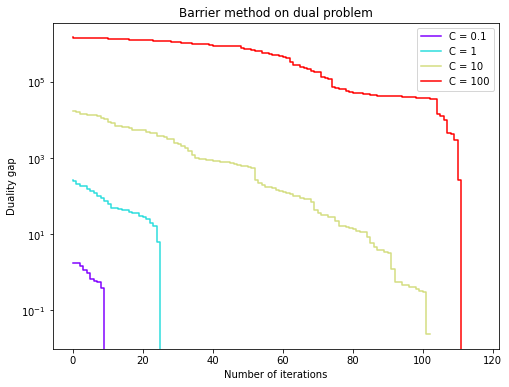

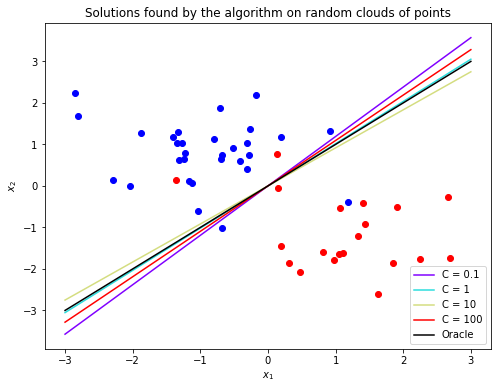

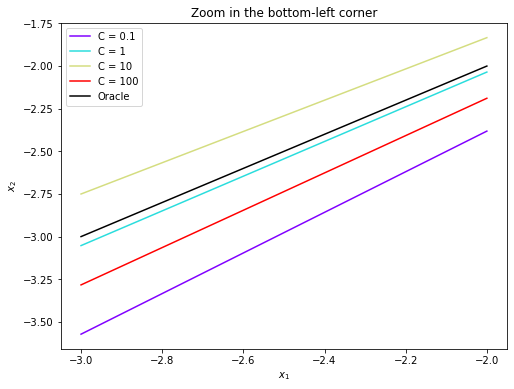

In [5]:
# Experiment with c = 0.1, 1, 10, 100 | m = 50

c_list = [0.1, 1, 10, 100]
x, y, a_stars, w_stars = plot_all(c_list, m=50, n=2, eps=1e-7, random_seed=1)

$C=1$ leads to the best fit, although they all fit the data quite well.